# Behavioural clone

Given multiple replays of expert trajectorys \[(s_1, a_1), (s_2, a_2), ...\]  
use a neural network to predict the 'a' actions from the 's' states.

In [1]:
# PARAMS
EXPERT_PLAYER_IDX = 0
USE_GPU = False

GAMES = [{"id": gameID} for gameID in ["noBoost1v1_1", "noBoost1v1_2", "noBoost1v1_3"]]

# NOTE: can't use __file__ in jupyter notebook unfortunately, so hard-code it insteadL
ROOT_PROJECT_PATH = 'C:/Users/User/code/CPSC533V/project'

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
DEVICE = torch.device("cuda" if USE_GPU else "cpu")

# Load local reusable code within 'lib/'
sys.path.append(ROOT_PROJECT_PATH)
import lib.files as libFiles
import lib.preprocess as libPreprocess
from lib.StoAModel import StoA_Model

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Parse the games from .replay files

In [4]:
for game in GAMES:
    game['data'] = libFiles.parseReplayToGameData(game['id'])
    libFiles.cleanAndDisplayGameData(game['data'])

Loading...
	replays\noBoost1v1_1.replay


Could not find field_of_view in camera settings for Sundown
Could not find height in camera settings for Sundown
Could not find pitch in camera settings for Sundown
Could not find distance in camera settings for Sundown
Could not find stiffness in camera settings for Sundown
Could not find swivel_speed in camera settings for Sundown
Could not find transition_speed in camera settings for Sundown
D:/projects/carball\carball\controls\rotations.py:87: RuntimeWarning: invalid value encountered in sign
  rhs[1] / (T_p + np.sign(rhs[1]) * omega[1] * D_p),
D:/projects/carball\carball\controls\rotations.py:88: RuntimeWarning: invalid value encountered in sign
  rhs[2] / (T_y - np.sign(rhs[2]) * omega[2] * D_y)


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12921 data points acquired
====


Loading...
	replays\noBoost1v1_2.replay


Could not find field_of_view in camera settings for Beast
Could not find height in camera settings for Beast
Could not find pitch in camera settings for Beast
Could not find distance in camera settings for Beast
Could not find stiffness in camera settings for Beast
Could not find swivel_speed in camera settings for Beast
Could not find transition_speed in camera settings for Beast


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12016 data points acquired
====


Loading...
	replays\noBoost1v1_3.replay


Could not find field_of_view in camera settings for Middy
Could not find height in camera settings for Middy
Could not find pitch in camera settings for Middy
Could not find distance in camera settings for Middy
Could not find stiffness in camera settings for Middy
Could not find swivel_speed in camera settings for Middy
Could not find transition_speed in camera settings for Middy


2 players loaded!

Orange team:
	bot

Blue team:
	expert

12682 data points acquired
====




In [5]:
# For debugging purposes, check the values loaded:
print ("Player values recorded:")
for pp in list(GAMES[0]['data'].players[0].data):
    print (" * " + pp)
    
print ("\nBall values recorded:")
for bp in list(GAMES[0]['data'].ball):
    print (" * " + bp)

Player values recorded:
 * ping
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * throttle
 * steer
 * handbrake
 * ball_cam
 * boost
 * boost_active
 * jump_active
 * double_jump_active
 * dodge_active
 * boost_collect

Ball values recorded:
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * hit_team_no


## Preprocess all loaded data

Keep only needed values, fill in missing ones, and normalize all ranges.

In [6]:
for game in GAMES:
    gameData = game['data']
    
    game['playerStates'], game['playerActions'] = [], []
    for p in gameData.players:
        game['playerStates' ].append(libPreprocess.cleanPlayerStates( p.data    ))
        game['playerActions'].append(libPreprocess.cleanPlayerActions(p.controls))
    game['ballStates'] = libPreprocess.cleanBallStates(gameData.ball)
    print ("Game data from '%s' preprocessed." % game['id'])
    print ("    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys\n")
    

Game data from 'noBoost1v1_1' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys

Game data from 'noBoost1v1_2' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys

Game data from 'noBoost1v1_3' preprocessed.
    ... clean data available at 'playerStates', 'playerActions' and 'ballStates' keys



## Distrubutions of values

Histogram for the distribution of values of each state and columns

Player states:


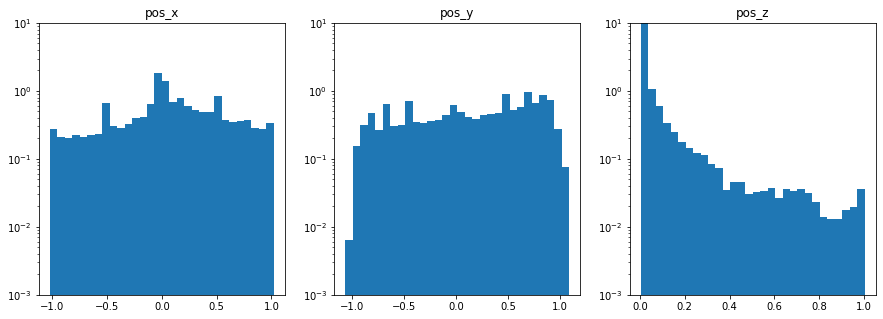

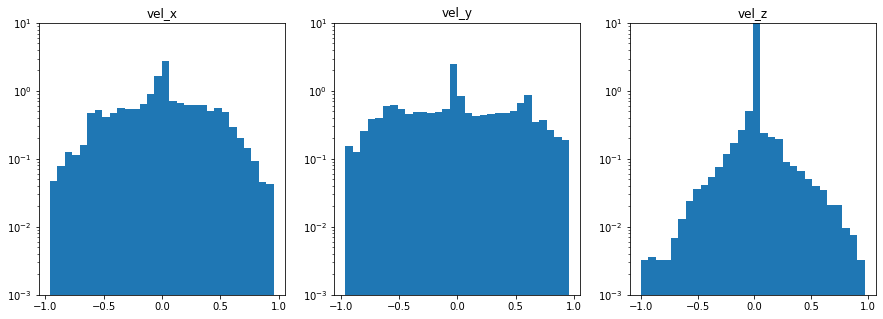

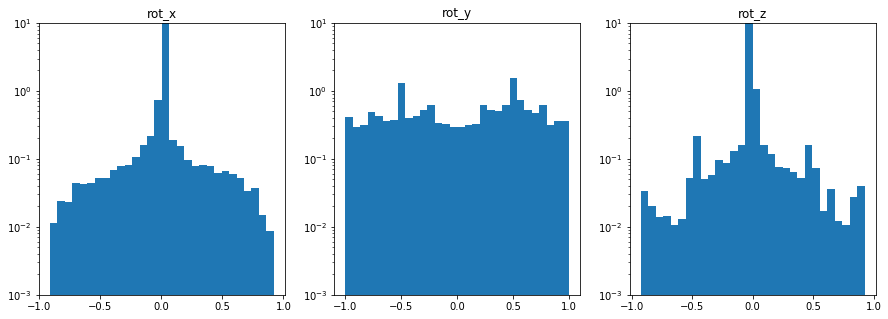

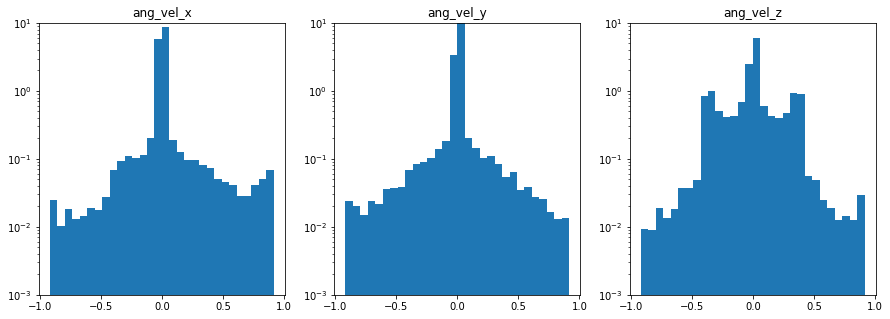

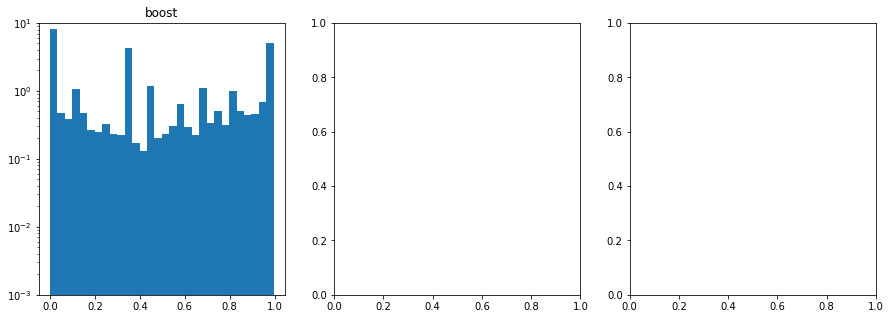

Player actions:


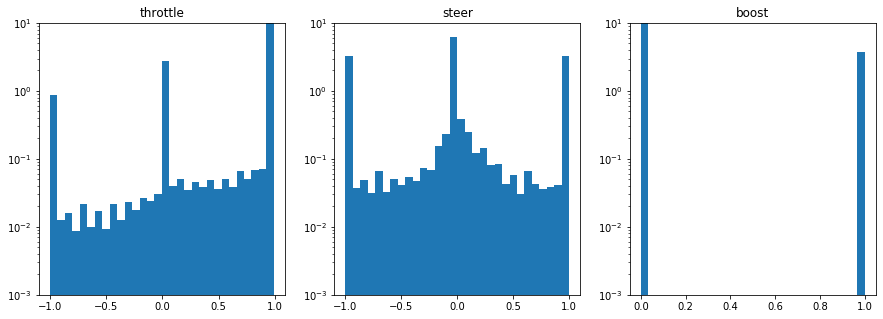

Ball states:


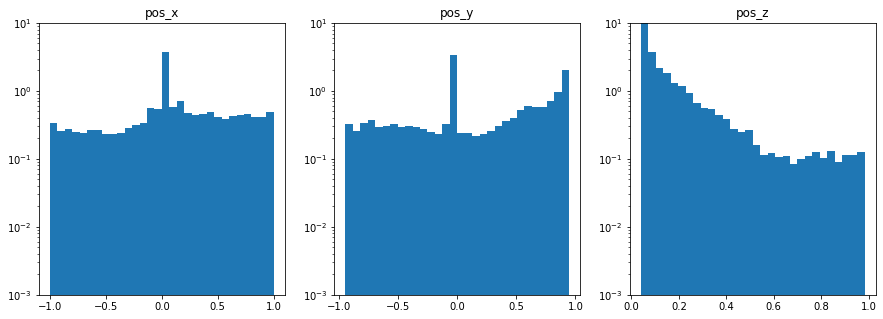

In [7]:
def showDistributions():
    print ("Player states:")

    allPlayerStates  = [s for game in GAMES for s in game['playerStates'] ]
    allPlayerActions = [a for game in GAMES for a in game['playerActions']]
    allBallStates    = [game['ballStates'] for game in GAMES]
    
    for i in range(0, len(libPreprocess.PLAYER_STATE_KEYS), 3):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for j in range(3):
            if i + j >= len(libPreprocess.PLAYER_STATE_KEYS):
                break
            key = libPreprocess.PLAYER_STATE_KEYS[i + j]
            allValues = []
            for pState in allPlayerStates:
                allValues.extend(pState[key].values)
            ax[j].hist(allValues, log=True, bins=30, density=True)
            ax[j].set_title(key)
            ax[j].set_ylim((1e-3, 10))
        plt.show()

    print ("Player actions:")
    for i in range(0, len(libPreprocess.PLAYER_ACTION_KEYS), 3):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for j in range(3):
            if i + j >= len(libPreprocess.PLAYER_ACTION_KEYS):
                break
            key = libPreprocess.PLAYER_ACTION_KEYS[i + j]
            allValues = []
            for pAct in allPlayerActions:
                allValues.extend(pAct[key].values * 1.0)
            ax[j].hist(allValues, log=True, bins=30, density=True)
            ax[j].set_title(key)
            ax[j].set_ylim((1e-3, 10))
        plt.show()

    print ("Ball states:")
    for i in range(0, len(libPreprocess.BALL_STATE_KEYS), 3):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for j in range(3):
            if i + j >= len(libPreprocess.BALL_STATE_KEYS):
                break
            key = libPreprocess.BALL_STATE_KEYS[i + j]
            allValues = []
            for bState in allBallStates:
                allValues.extend(bState[key].values)
            ax[j].hist(allValues, log=True, bins=30, density=True)
            ax[j].set_title(key)
            ax[j].set_ylim((1e-3, 10))
        plt.show()
    
showDistributions()

## Extract expert states and actions

Combine ball state and all player states into one dataframe, labelled appropriately for the expert player.


In [8]:
for game in GAMES:
    game['expertStates'], game['expertActions'] = libPreprocess.stateAndActionsForPlayer(game, EXPERT_PLAYER_IDX)
    print ("State and action maps for player %s" % game['data'].players[EXPERT_PLAYER_IDX].name)
    print (game['expertStates'].values.shape, game['expertStates'].values.dtype)
    print (game['expertActions'].values.shape, game['expertActions'].values.dtype)
    print ("=======\n\n")

State and action maps for player expert
(12921, 29) float64
(12921, 3) object


State and action maps for player expert
(12016, 29) float64
(12016, 3) object


State and action maps for player expert
(12682, 29) float64
(12682, 3) object




## Train the model

Using all the data, collect into batches and train the model for a number of epochs,  
and save the result to file for use within the game.

In [10]:
TOTAL_EPOCHS = 300
BATCH_SZ = 100
#PRINT_INTERVAL = 1000
LOG_INTERVAL = 1000
LEARNING_RATE = 0.0003
REGULARIZER_WEIGHT = 3e-2

W_ALOSS = 100
W_DLOSS = 50

writer = SummaryWriter()

def train_behavioral_cloning(dataBatches, model):
    # Adam optimizer usually a good default.
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZER_WEIGHT)
    
    # MSE loss for [-1, 1] continuous variables:
    analog_loss_func = torch.nn.MSELoss().to(DEVICE)
    
    # Cross entropy loss for binary variables:
    digital_loss_func = torch.nn.BCEWithLogitsLoss().to(DEVICE)

    gradient_steps = 0

    for epoch in range(1, TOTAL_EPOCHS + 1):
        batchShuffled = random.sample(dataBatches, len(dataBatches))
        lastLoss = -1
        for iteration, data in enumerate(batchShuffled):
            data = {k: v.to(DEVICE) for k, v in data.items()}
            output = model(data['s'])
            analogAction = 2 * torch.sigmoid(data['aAnalog']) - 1
            digitalAction = data['aDigital']
            
            aasz = len(libPreprocess.PLAYER_ANALOG_ACTION_KEYS)
            aLoss = W_ALOSS * analog_loss_func(output[:, :aasz], analogAction)
            dLoss = W_DLOSS * digital_loss_func(output[:, aasz:], digitalAction)
            loss = aLoss + dLoss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if gradient_steps % LOG_INTERVAL == 0:
                writer.add_scalar('analogLoss', aLoss.item(), gradient_steps)
                writer.add_scalar('digitalLoss', dLoss.item(), gradient_steps)
                writer.add_scalar('loss', loss.item(), gradient_steps)
            
            gradient_steps += 1
            
            if iteration == len(batchShuffled) - 1:
                lastLoss = loss.item()
            
        print ('[epoch {:4d}/{}] [iter {:7d}] [loss {:.5f}]'.format(
           epoch, TOTAL_EPOCHS, gradient_steps, lastLoss)
        )
    
def runTraining():
    combinedStates  = pd.concat([game['expertStates']  for game in GAMES])
    combinedActions = pd.concat([game['expertActions'] for game in GAMES])
    
    dataBatches, stateSz, actionAnalogSz, actionDigitalSize = \
        libPreprocess.dataToBatches(combinedStates, combinedActions, BATCH_SZ, splitActions=True)
    
    model = StoA_Model(stateSz, actionAnalogSz + actionDigitalSize, DEVICE)
    train_behavioral_cloning(dataBatches, model)
    model.save("bc.all3Replays")
    return model

model = runTraining()


37619 rows, 29 state dim, 3 action dim, into 377 batches of size 100
[epoch    1/300] [iter     377] [loss 40.74430]
[epoch    2/300] [iter     754] [loss 31.09900]
[epoch    3/300] [iter    1131] [loss 25.51734]
[epoch    4/300] [iter    1508] [loss 30.41732]
[epoch    5/300] [iter    1885] [loss 24.15697]
[epoch    6/300] [iter    2262] [loss 25.67808]
[epoch    7/300] [iter    2639] [loss 19.98825]
[epoch    8/300] [iter    3016] [loss 19.33655]
[epoch    9/300] [iter    3393] [loss 19.55820]
[epoch   10/300] [iter    3770] [loss 22.24596]
[epoch   11/300] [iter    4147] [loss 18.06550]
[epoch   12/300] [iter    4524] [loss 17.82089]
[epoch   13/300] [iter    4901] [loss 18.53518]
[epoch   14/300] [iter    5278] [loss 19.86867]
[epoch   15/300] [iter    5655] [loss 19.74246]
[epoch   16/300] [iter    6032] [loss 18.00149]
[epoch   17/300] [iter    6409] [loss 15.26924]
[epoch   18/300] [iter    6786] [loss 16.37003]
[epoch   19/300] [iter    7163] [loss 23.18381]
[epoch   20/300] [i

[epoch  171/300] [iter   64467] [loss 15.52763]
[epoch  172/300] [iter   64844] [loss 12.03331]
[epoch  173/300] [iter   65221] [loss 16.38191]
[epoch  174/300] [iter   65598] [loss 9.47356]
[epoch  175/300] [iter   65975] [loss 10.19114]
[epoch  176/300] [iter   66352] [loss 11.64857]
[epoch  177/300] [iter   66729] [loss 13.75260]
[epoch  178/300] [iter   67106] [loss 13.28499]
[epoch  179/300] [iter   67483] [loss 9.78864]
[epoch  180/300] [iter   67860] [loss 14.51688]
[epoch  181/300] [iter   68237] [loss 12.39606]
[epoch  182/300] [iter   68614] [loss 14.92381]
[epoch  183/300] [iter   68991] [loss 19.52020]
[epoch  184/300] [iter   69368] [loss 10.19977]
[epoch  185/300] [iter   69745] [loss 11.58982]
[epoch  186/300] [iter   70122] [loss 14.51229]
[epoch  187/300] [iter   70499] [loss 13.39183]
[epoch  188/300] [iter   70876] [loss 9.39138]
[epoch  189/300] [iter   71253] [loss 12.64128]
[epoch  190/300] [iter   71630] [loss 15.21832]
[epoch  191/300] [iter   72007] [loss 13.77